# Sentiment Analysis
This notebook explores sentiment analysis on an Amazon Fine Food Reviews dataset using Natural Language Processing (NLP) techniques. A comprehensive analysis of sentiment analysis techniques is conducted, offering insights into the performance of both traditional and state-of-the-art NLP models.

We will explore:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of Words approach
2. RoBERTa pre-trained Model from Hugging Face - advanced transformer model
3. Comparison of performance between the two models
4. Hugging Face Pipeline


### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### Read in data

In [2]:
df = pd.read_csv('input/Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)
df.head()

(568454, 10)
(500, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Quick EDA

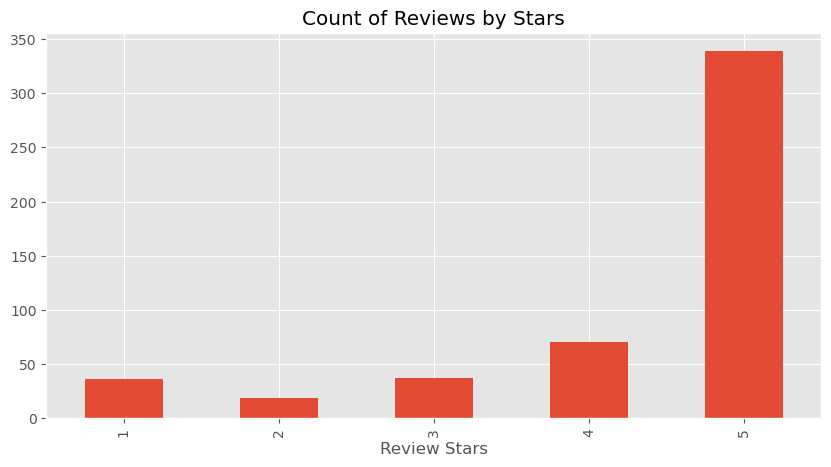

In [3]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

Most of the reviews are 5 stars. There are fewer reviews for lower ratings, with a small uptick in the number of 1 star reviews. \
The data set is very biased towards positive review.

### Basic NLTK
Uses one example review to perform basic NLP tasks such as tokenization and part-of-speech tagging.

In [4]:
# Take the 50th value of the 'Text' column as an example
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [5]:
# Tokenize the sentence (in NLP you often need to convert the text into some format the computer can interpret)
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [6]:
# Find the part of speech values for each of these tokens (see definitions in POS_codes.txt)
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [7]:
# Groups tokens in chunks of text 
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## 1. VADER Sentiment Scoring
We will use NLTK's SentimentIntensityAnalyzer to get the negative/neutral/positive scores of the text.

- This uses a "Bag of Words" approach:
  1. Stop words are removed
  2. Each word is scored and combined to a total score.

NOTE: This approach does not account for relationships between words.

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


neg, neu, pos scores range from 0 to +1. \
compound score ranges from -1 to +1.

In [9]:
# Run the `sia` object on text to see what the sentiment is 
sia.polarity_scores('I am so pleased!')

{'neg': 0.0, 'neu': 0.365, 'pos': 0.635, 'compound': 0.54}

In [10]:
sia.polarity_scores('This is the worst product I have ever bought.')

{'neg': 0.369, 'neu': 0.631, 'pos': 0.0, 'compound': -0.6249}

In [11]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [12]:
# Run the polarity score on the entire dataset
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    results[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
# Sentiment score and metadata
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plot VADER results
We would expect that a Score of 1 will have a lower compound score and a Score of 5 will have a higher compound score.

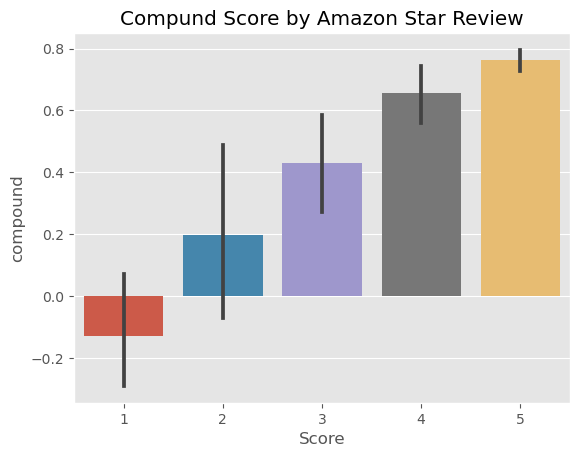

In [14]:
# Plotting compound score against review Score
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

This is what we would expect. The higher the Score, the more positive the overall text sentiment.

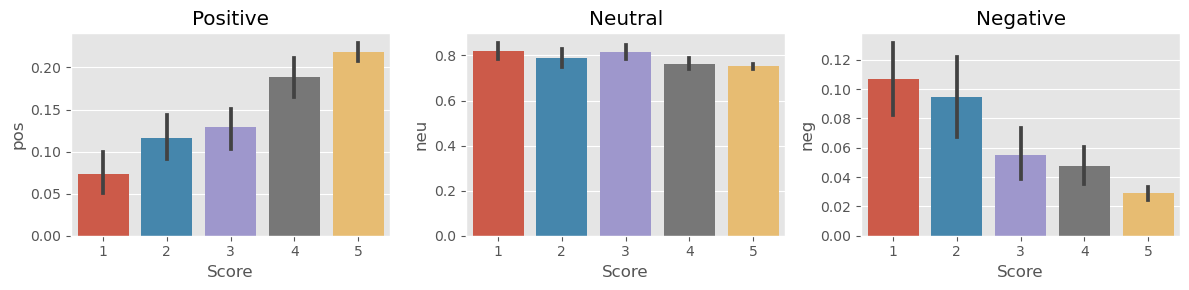

In [15]:
# Plotting pos, neu, neg scores against review Score
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Positivity increases as the Score increases. Neutrality is fairly flat across all scores. Negativity decreases as the Score increases.

This confirms what we would hope to see and demonstrates that VADER is valuable in identifying the relationship between sentiment score and the rating Score of the reviewers.

## 2. RoBERTa Pre-trained Model
This section introduces the RoBERTa pre-trained model for sentiment analysis. It demonstrates how to use the model to predict sentiment scores for text data and compares the results with VADER scores.

In [17]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

OSError: [WinError 126] The specified module could not be found. Error loading "c:\Users\User\anaconda3\Lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

We utilise Hugging Face's pre-trained sentiment model, which was trained on labeled Twitter comments. By loading the model and tokenizer from a pre-trained checkpoint, we leverage transfer learning. This approach allows us to apply the pre-trained weights directly to our dataset without the need for retraining.

In [9]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

RuntimeError: Failed to import transformers.models.roberta.modeling_roberta because of the following error (look up to see its traceback):
[WinError 126] The specified module could not be found. Error loading "c:\Users\User\anaconda3\Lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

Now we have a model and a tokenizer that we can apply to the review Text.

In [ ]:
# VADER results on example
print(example)
sia.polarity_scores(example)

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

### Combining and Comparing Results
Here, the results from VADER sentiment analysis and the RoBERTa model are combined and compared. Pair plots are used to visualise the relationship between sentiment scores from different models.

In [ ]:
# Step 3. Combine and compare
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

### Review Examples
Examining specific examples where sentiment scores from VADER and RoBERTa differ the most. Examples include positive 1-star and negative 5-star reviews, providing insights into the effectiveness of each model.

In [ ]:
# Step 4: Review Examples: Positive 1-Star and Negative 5-Star Reviews
# Positive sentiment 1-Star view
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

In [ ]:
# Negative sentiment 5-Star view
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

### Transformers Pipeline
This section demonstrates the use of the Transformers pipeline for quick and easy sentiment predictions.

In [ ]:
# Extra: The Transformers Pipeline
# Quick & easy way to run sentiment predictions
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")
sent_pipeline('I love sentiment analysis!')
sent_pipeline('Make sure to like and subscribe!')
sent_pipeline('booo')

# COMPARISON
VADER looked at each word in the review and scored each word individually.
However human language depends a lot on context. A sentence may be sarcastic, or the words may be related in such a way that individual 'negative' words have a positive meaning and vice versa.

Transformer-based deep learning models have become popular as they can pick up on that context. we are going to use Huggingface (a leader in this type of models)